In [1]:
import pandas as pd
movie_reviews = pd.read_csv("train.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape


(156060, 4)

In [2]:
movie_reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
import pandas as pd
test_reviews = pd.read_csv("test.csv")

test_reviews.isnull().values.any()

test_reviews.shape


(66292, 3)

In [4]:
test_reviews.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


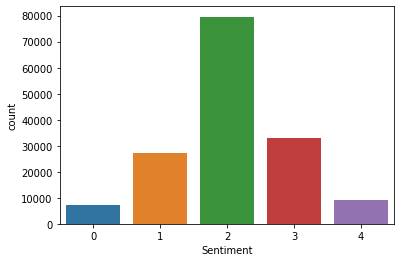

In [5]:
import seaborn as sns

sns.countplot(x='Sentiment', data=movie_reviews)

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LeakyReLU

Using TensorFlow backend.


In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dark1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import re

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

stemmer=nltk.stem.WordNetLemmatizer()
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
   
    remove_tags(text)  
    # text = re.sub('[^a-zA-Z]', ' ', text)# Remove punctuations and numbers
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)# Single character removal
    # text = re.sub(r'\s+', ' ', text)# Removing multiple spaces
    text = text.lower()# lowercase text  
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = re.sub(BAD_SYMBOLS_RE,' ',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    
    text = ' '.join(s for s in text.split() if s not in STOPWORDS)# delete stopwords from text  
    text = ' '.join(stemmer.lemmatize(token) for token in text.split())
    return text

In [10]:
X = []
sentences = list(movie_reviews['Phrase'])
for sen in sentences:
    X.append(text_prepare(sen))

In [11]:
X[8]

'escapade'

In [12]:
import numpy as np

Y=movie_reviews['Sentiment']
Y = np.array(Y)
Y=np.array(list(Y))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
np.count_nonzero(Y_train == 2)

63943

In [15]:
np.count_nonzero(Y_test == 2)

15639

In [16]:
np.count_nonzero(Y_train == 1)

21746

In [17]:
np.count_nonzero(Y_test == 1)

5527

In [18]:
np.count_nonzero(Y_train == 0)

5656

In [19]:
np.count_nonzero(Y_test == 0)

1416

In [20]:
np.count_nonzero(Y_train == 3)

26220

In [21]:
np.count_nonzero(Y_test == 3)

6707

In [22]:
np.count_nonzero(Y_train == 4)

7283

In [23]:
np.count_nonzero(Y_test == 4)

1923

In [24]:
from collections import defaultdict

words_counts = defaultdict(int)
for text in X_train:
    for word in text.split():
        words_counts[word] += 1

In [25]:
#print(words_counts)

In [26]:
#print(len(words_counts))

In [27]:
DICT_SIZE = 9632
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]
WORDS_TO_INDEX = {p[0]:i for i,p in enumerate(most_common_words[:DICT_SIZE])}
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split():
        if word in words_to_index:
            result_vector[words_to_index[word]] += 1
    return result_vector


In [28]:
#print(most_common_words)

In [29]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])


X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])


In [30]:
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (124848, 9632)
X_test shape  (31212, 9632)


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
def tfidf_features(X_train, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(min_df=10,max_df=0.80,ngram_range=(1,2))
    X_train = tfidf_vectorizer.fit_transform(X_train)   
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train,X_test, tfidf_vectorizer.vocabulary_

In [33]:
X_train_tfidf,X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

In [34]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_tk = tokenizer.texts_to_sequences(X_train)
X_test_tk = tokenizer.texts_to_sequences(X_test)

In [35]:
print(X_train[3]) 

somewhere sling blade south heaven west hell


In [36]:
X_train_tk[3]

[1016, 9965, 958, 851, 1004, 1666, 723]

In [37]:
maxlen=20
X_train_tk = pad_sequences(X_train_tk, padding='post', maxlen=maxlen)
X_test_tk = pad_sequences(X_test_tk, padding='post', maxlen=maxlen)

In [38]:
X_train_tk[3]

array([1016, 9965,  958,  851, 1004, 1666,  723,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [39]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [40]:
vocab_size = len(tokenizer.word_index)+1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [41]:
from keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_test_oh= to_categorical(Y_test)
print(Y_train_oh[3])

[0. 0. 1. 0. 0.]


In [42]:
print( len(embedding_matrix))
print(len(embedding_matrix[0]))

13759
100


In [43]:
class_weight = {0: 8.,
                1: 3.,
                2: 1.,
                3: 3.,
                4: 8.}

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model = LogisticRegression()
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [79]:
from sklearn import metrics

In [80]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[  340,   625,   417,    30,     4],
       [  198,  1849,  3238,   227,    15],
       [   35,   718, 14027,   811,    48],
       [    7,   168,  3414,  2767,   351],
       [    1,    21,   352,   953,   596]], dtype=int64)

In [81]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred_mybag)

0.6272907855952838

In [82]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [83]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  223,   709,   438,    45,     1],
       [  102,  1774,  3396,   245,    10],
       [   25,   662, 14021,   894,    37],
       [    4,   129,  3400,  2974,   200],
       [    0,    23,   367,  1134,   399]], dtype=int64)

In [84]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6212674612328591

In [85]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [86]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[    8,   102,  1249,    54,     3],
       [   13,   269,  5071,   166,     8],
       [    9,   243, 15214,   171,     2],
       [   15,   260,  6240,   187,     5],
       [    6,   111,  1737,    64,     5]], dtype=int64)

In [87]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5024669998718442

In [88]:
from sklearn.svm import SVC

In [89]:
model = SVC(C=100)
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [90]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[   13,   439,   920,    44,     0],
       [    5,   745,  4570,   207,     0],
       [    4,   306, 14853,   474,     2],
       [    2,   135,  4847,  1715,     8],
       [    0,    24,   919,   934,    46]], dtype=int64)

In [91]:
accuracy_score(Y_test, Y_pred_mybag)

0.5565808022555427

In [92]:
model = SVC(C=100)
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)


C:\Users\dark1\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [93]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[    0,     0,  1415,     1,     0],
       [    0,     0,  5517,    10,     0],
       [    0,     0, 15626,    13,     0],
       [    0,     0,  6672,    35,     0],
       [    0,     0,  1911,    12,     0]], dtype=int64)

In [94]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5017621427656029

In [120]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [121]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  514,   549,   224,    93,    36],
       [  581,  2372,  2028,   440,   106],
       [  305,  2026, 11282,  1825,   201],
       [  124,   547,  2574,  2821,   641],
       [   57,   136,   310,   831,   589]], dtype=int64)

In [122]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5631808278867102

In [98]:
from sklearn.ensemble import RandomForestClassifier

In [99]:
model = RandomForestClassifier(100)
model.fit(X_train_mybag,Y_train)
Y_pred_rf=model.predict(X_test_mybag)

model.score(X_test_mybag,Y_test)

0.6368383954889145

In [100]:
from sklearn import metrics

In [101]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_rf)
cnf_matrix

array([[  528,   664,   209,    11,     4],
       [  451,  2630,  2238,   194,    14],
       [  113,  1372, 12528,  1545,    81],
       [    4,   164,  2423,  3378,   738],
       [    2,     6,   175,   927,   813]], dtype=int64)

In [102]:
accuracy_score(Y_test, Y_pred_rf)

0.6368383954889145

In [103]:
model = RandomForestClassifier(100)
model.fit(X_train_tfidf,Y_train)
Y_pred_tfidf=model.predict(X_test_tfidf)

model.score(X_test_tfidf,Y_test)

0.6336665385108292

In [104]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  513,   638,   244,    18,     3],
       [  442,  2543,  2311,   218,    13],
       [  114,  1378, 12537,  1526,    84],
       [    6,   172,  2417,  3380,   732],
       [    3,     9,   167,   939,   805]], dtype=int64)

In [105]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6336665385108292

In [125]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [126]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  513,   559,   217,   101,    26],
       [  575,  2387,  2020,   434,   111],
       [  298,  2014, 11265,  1857,   205],
       [  131,   549,  2558,  2825,   644],
       [   51,   142,   318,   835,   577]], dtype=int64)

In [127]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5628283993335896

In [109]:
from sklearn import tree

In [110]:
model= tree.DecisionTreeClassifier()

In [111]:
model.fit(X_train_mybag,Y_train)

Y_pred_mybag=model.predict(X_test_mybag)


In [112]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_mybag)
cnf_matrix

array([[  621,   606,   170,    13,     6],
       [  637,  2757,  1957,   158,    18],
       [  179,  1784, 12141,  1452,    83],
       [   16,   228,  2551,  3266,   646],
       [    5,    22,   201,   980,   715]], dtype=int64)

In [113]:
accuracy_score(Y_test, Y_pred_mybag)

0.6247597078046905

In [114]:
model.fit(X_train_tfidf,Y_train)

Y_pred_tfidf=model.predict(X_test_tfidf)



In [115]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  587,   597,   186,    42,     4],
       [  630,  2621,  2044,   208,    24],
       [  201,  1815, 12063,  1471,    89],
       [   32,   291,  2564,  3197,   623],
       [   14,    40,   225,   957,   687]], dtype=int64)

In [116]:
accuracy_score(Y_test, Y_pred_tfidf)

0.6137062668204537

In [128]:
model.fit(X_train_tk,Y_train)

Y_pred_tfidf=model.predict(X_test_tk)



In [129]:
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred_tfidf)
cnf_matrix

array([[  515,   556,   212,    97,    36],
       [  578,  2384,  2019,   448,    98],
       [  319,  2032, 11251,  1821,   216],
       [  126,   542,  2585,  2817,   637],
       [   53,   137,   317,   832,   584]], dtype=int64)

In [130]:
accuracy_score(Y_test, Y_pred_tfidf)

0.5623157759835961

In [89]:
from keras import metrics

In [92]:
from sklearn import metrics
from sklearn.metrics import recall_score  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
import matplotlib. pyplot as plt

In [ ]:
#word embedding

In [45]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(320, activation='tanh'))
model.add(Dense(160, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(80, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1375900   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 320)               640320    
_________________________________________________________________
dense_2 (Dense)              (None, 160)               51360     
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)               

In [46]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 34s 342us/step - loss: 3.6005 - acc: 0.4499 - recall_1: 0.6992 - precision_1: 0.3129 - val_loss: 3.2838 - val_acc: 0.5042 - val_recall_1: 0.7152 - val_precision_1: 0.3924
Epoch 2/6
99878/99878 [==============================] - 42s 416us/step - loss: 3.3811 - acc: 0.4649 - recall_1: 0.6713 - precision_1: 0.3614 - val_loss: 3.1874 - val_acc: 0.5087 - val_recall_1: 0.7090 - val_precision_1: 0.3900
Epoch 3/6
99878/99878 [==============================] - 36s 358us/step - loss: 3.2981 - acc: 0.4780 - recall_1: 0.6761 - precision_1: 0.3782 - val_loss: 3.1578 - val_acc: 0.4871 - val_recall_1: 0.6940 - val_precision_1: 0.3845ecall_1: 0.6765 - pre
Epoch 4/6
99878/99878 [==============================] - 34s 345us/step - loss: 3.2593 - acc: 0.4772 - recall_1: 0.6552 - precision_1: 0.3934 - val_loss: 3.1386 - val_acc: 0.4851 - val_recall_1: 0.6825 - val_precision_1: 0.3990
Epoch 5/6
99878/9

In [47]:
pr = model.predict(X_test_tk)

In [49]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1067  142   96  111    0]
 [2683 1010 1188  646    0]
 [2149 2277 9450 1763    0]
 [ 992  328 1962 3425    0]
 [ 191   40  167 1525    0]]


In [50]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4790465205690119

In [51]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.2311610918877356

In [52]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4790465205690119

In [53]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4790465205690119

In [54]:
 import matplotlib. pyplot as plt

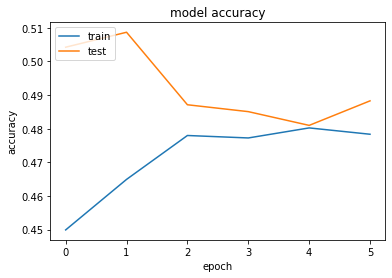

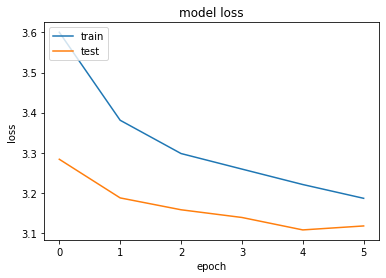

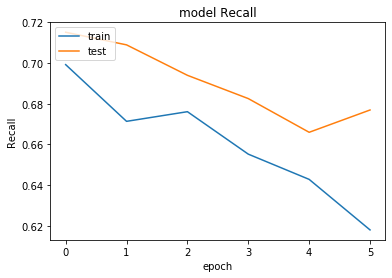

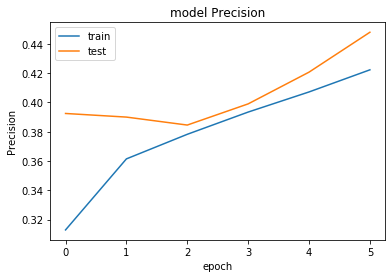

In [55]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [60]:
#cnn


In [57]:
from keras.layers import Activation,Conv1D,MaxPooling1D,Flatten
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

#model_cnn.add(MaxPooling1D())

model.add(Conv1D(320,2, activation='tanh'))
model.add(Conv1D(160,2, activation='tanh'))
model.add(MaxPooling1D())
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(80,2, activation='tanh'))
model.add(Conv1D(40,2, activation='tanh'))
model.add(MaxPooling1D())
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(Conv1D(20,2, activation='tanh'))
model.add(Conv1D(10,2, activation='tanh'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 100)           1375900   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 320)           64320     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 18, 160)           102560    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 160)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 160)            0         
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 9, 160)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 80)            

In [58]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 70s 700us/step - loss: 3.6273 - acc: 0.4281 - recall_2: 0.6747 - precision_2: 0.3227 - val_loss: 3.2648 - val_acc: 0.5207 - val_recall_2: 0.6927 - val_precision_2: 0.3721
Epoch 2/6
99878/99878 [==============================] - 73s 733us/step - loss: 3.3467 - acc: 0.4862 - recall_2: 0.6975 - precision_2: 0.3601 - val_loss: 3.1225 - val_acc: 0.5274 - val_recall_2: 0.7053 - val_precision_2: 0.4104
Epoch 3/6
99878/99878 [==============================] - 72s 725us/step - loss: 3.2713 - acc: 0.5033 - recall_2: 0.6826 - precision_2: 0.3892 - val_loss: 3.0866 - val_acc: 0.5348 - val_recall_2: 0.7141 - val_precision_2: 0.4227- precisi
Epoch 4/6
99878/99878 [==============================] - 72s 724us/step - loss: 3.2392 - acc: 0.5030 - recall_2: 0.6701 - precision_2: 0.4017 - val_loss: 3.0847 - val_acc: 0.5119 - val_recall_2: 0.6465 - val_precision_2: 0.4072
Epoch 5/6
99878/99878 [======

In [60]:
pr = model.predict(X_test_tk)

In [61]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1055  156   81  122    2]
 [2704  926 1118  757   22]
 [2078 1555 9610 2383   13]
 [ 744  313 1637 3984   29]
 [ 105   32  112 1665    9]]


In [62]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4992951428937588

In [63]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.110310137126746

In [64]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4992951428937588

In [65]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4992951428937588

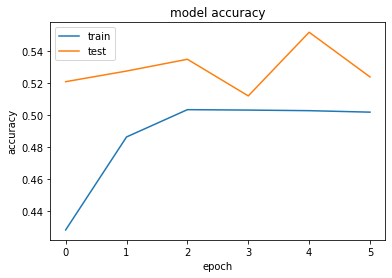

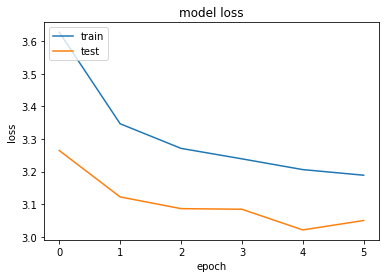

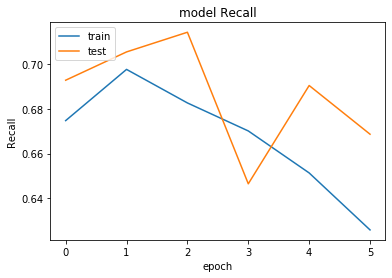

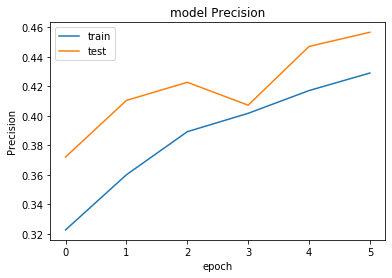

In [66]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_2'])
plt.plot(history.history['val_recall_2'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [48]:
#lstm

In [68]:
from keras.layers import Embedding,LSTM
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)


model.add(LSTM(320,return_sequences = True))
model.add(LSTM(160,return_sequences = True))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(LSTM(80,return_sequences = True))
model.add(LSTM(40,return_sequences = True))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(LSTM(20,return_sequences = True))
model.add(LSTM(10,return_sequences = False))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 100)           1375900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 320)           538880    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 160)           307840    
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 160)           0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 20, 160)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 80)            77120     
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 40)           

In [69]:
history = model.fit(X_train_tk, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 666s 7ms/step - loss: 3.7854 - acc: 0.3822 - recall_3: 0.7104 - precision_3: 0.2563 - val_loss: 3.5028 - val_acc: 0.5376 - val_recall_3: 0.8332 - val_precision_3: 0.3028
Epoch 2/6
99878/99878 [==============================] - 596s 6ms/step - loss: 3.4265 - acc: 0.5077 - recall_3: 0.7258 - precision_3: 0.3273 - val_loss: 3.1711 - val_acc: 0.5744 - val_recall_3: 0.7844 - val_precision_3: 0.3747
Epoch 3/6
99878/99878 [==============================] - 585s 6ms/step - loss: 3.1794 - acc: 0.5281 - recall_3: 0.7056 - precision_3: 0.3993 - val_loss: 3.0015 - val_acc: 0.5777 - val_recall_3: 0.7248 - val_precision_3: 0.4493
Epoch 4/6
99878/99878 [==============================] - 617s 6ms/step - loss: 3.0381 - acc: 0.5384 - recall_3: 0.6902 - precision_3: 0.4364 - val_loss: 2.9249 - val_acc: 0.5761 - val_recall_3: 0.7305 - val_precision_3: 0.4376
Epoch 5/6
99878/99878 [===================

In [71]:
pr = model.predict(X_test_tk)

In [72]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[ 1159   120    77    60     0]
 [ 2845  1138  1123   421     0]
 [ 1671  1928 10494  1546     0]
 [  404   361  2112  3830     0]
 [   36    33   150  1704     0]]


In [73]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5325195437652185

In [74]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.8697616301422529

In [75]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5325195437652185

In [76]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.5325195437652185

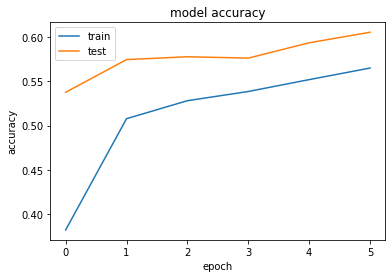

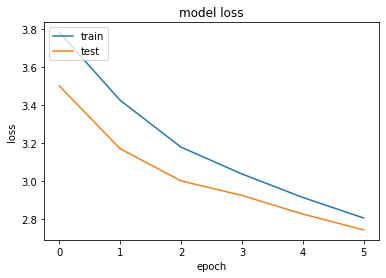

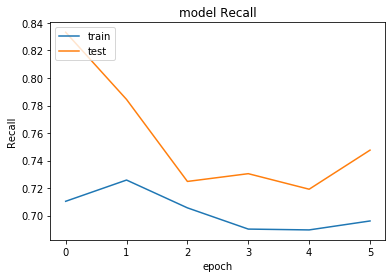

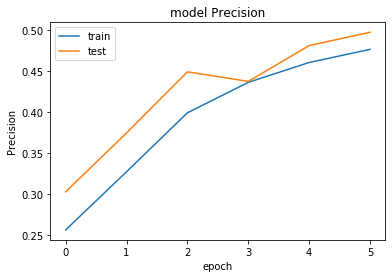

In [77]:
    
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_3'])
plt.plot(history.history['val_recall_3'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_3'])
plt.plot(history.history['val_precision_3'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [65]:
#tfidf

In [79]:
model = Sequential()

model.add(Dense(320,input_shape= (16694,), activation='tanh'))
model.add(Dense(160, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(80, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 320)               5342400   
_________________________________________________________________
dense_11 (Dense)             (None, 160)               51360     
_________________________________________________________________
dropout_10 (Dropout)         (None, 160)               0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 160)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_13 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)               

In [80]:
history = model.fit(X_train_tfidf, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 213s 2ms/step - loss: 3.4078 - acc: 0.3301 - recall_4: 0.7928 - precision_4: 0.3102 - val_loss: 3.0319 - val_acc: 0.4350 - val_recall_4: 0.7628 - val_precision_4: 0.3517
Epoch 2/6
99878/99878 [==============================] - 225s 2ms/step - loss: 2.9954 - acc: 0.4744 - recall_4: 0.7772 - precision_4: 0.3829 - val_loss: 2.8915 - val_acc: 0.4835 - val_recall_4: 0.7578 - val_precision_4: 0.4064
Epoch 3/6
99878/99878 [==============================] - 200s 2ms/step - loss: 2.8289 - acc: 0.5119 - recall_4: 0.7727 - precision_4: 0.4306 - val_loss: 2.8221 - val_acc: 0.4901 - val_recall_4: 0.7464 - val_precision_4: 0.4416
Epoch 4/6
99878/99878 [==============================] - 192s 2ms/step - loss: 2.7430 - acc: 0.5370 - recall_4: 0.7399 - precision_4: 0.4629 - val_loss: 2.8111 - val_acc: 0.4606 - val_recall_4: 0.6992 - val_precision_4: 0.4339
Epoch 5/6
99878/99878 [===================

In [82]:
pr = model.predict(X_test_tfidf)

In [83]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[1140  139   98   38    1]
 [2418 1123 1498  486    2]
 [1446 1851 7997 4343    2]
 [ 211  203 1289 5003    1]
 [  25    5   73 1817    3]]


In [84]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4891067538126362

In [85]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.8108419838523645

In [86]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.4891067538126362

In [87]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.4891067538126362

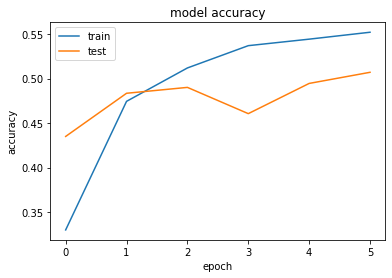

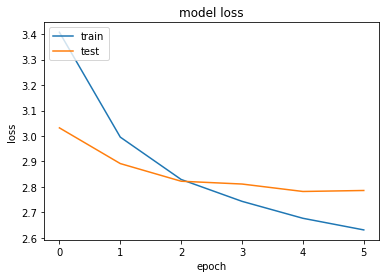

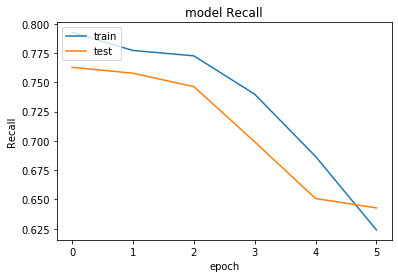

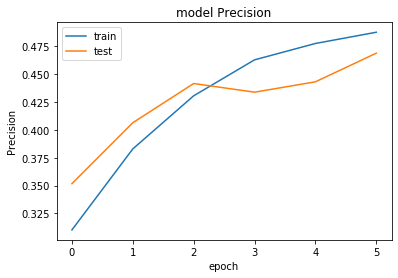

In [88]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_4'])
plt.plot(history.history['val_precision_4'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [71]:
#bag of words

In [90]:
model = Sequential()

model.add(Dense(320,input_shape= (9632,), activation='tanh'))
model.add(Dense(160, activation='tanh'))
model.add(Dropout(0.6))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(80, activation='tanh'))
model.add(Dense(40, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(20, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dropout(0.4))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc',metrics.Recall(),metrics.Precision()])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 320)               3082560   
_________________________________________________________________
dense_18 (Dense)             (None, 160)               51360     
_________________________________________________________________
dropout_13 (Dropout)         (None, 160)               0         
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 160)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_20 (Dense)             (None, 40)                3240      
_________________________________________________________________
dropout_14 (Dropout)         (None, 40)               

In [91]:
history = model.fit(X_train_mybag, Y_train_oh, batch_size=80, epochs=6, verbose=1, validation_split=0.2,class_weight=class_weight)

Train on 99878 samples, validate on 24970 samples
Epoch 1/6
99878/99878 [==============================] - 130s 1ms/step - loss: 3.4414 - acc: 0.3670 - recall_5: 0.7143 - precision_5: 0.3190 - val_loss: 2.9824 - val_acc: 0.4778 - val_recall_5: 0.7746 - val_precision_5: 0.3760
Epoch 2/6
99878/99878 [==============================] - 126s 1ms/step - loss: 2.9827 - acc: 0.4937 - recall_5: 0.7557 - precision_5: 0.4038 - val_loss: 2.8199 - val_acc: 0.5115 - val_recall_5: 0.7503 - val_precision_5: 0.4225
Epoch 3/6
99878/99878 [==============================] - 124s 1ms/step - loss: 2.8377 - acc: 0.5136 - recall_5: 0.7223 - precision_5: 0.4374 - val_loss: 2.7552 - val_acc: 0.5530 - val_recall_5: 0.7596 - val_precision_5: 0.4798
Epoch 4/6
99878/99878 [==============================] - 126s 1ms/step - loss: 2.7375 - acc: 0.5291 - recall_5: 0.6798 - precision_5: 0.4647 - val_loss: 2.7294 - val_acc: 0.5705 - val_recall_5: 0.7292 - val_precision_5: 0.4888
Epoch 5/6
99878/99878 [===================

In [93]:
pr = model.predict(X_test_mybag)

In [94]:
cnf_matrix = metrics.confusion_matrix(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))
print(cnf_matrix)

[[ 1217    95    86    10     8]
 [ 2853   721  1706   183    64]
 [ 2212   826 10167  2171   263]
 [  711   118  1621  2850  1407]
 [  121    10    86   511  1195]]


In [95]:
recall_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5174291938997821

In [96]:
mean_squared_error(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

1.0316865308214789

In [97]:
precision_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1),average='micro')

0.5174291938997821

In [98]:
accuracy_score(Y_test_oh.argmax(axis=1), pr.round().argmax(axis=1))

0.5174291938997821

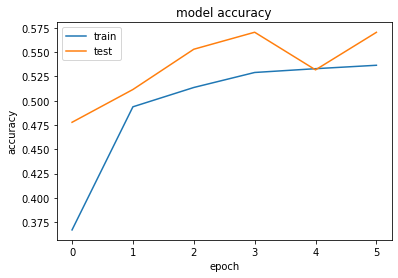

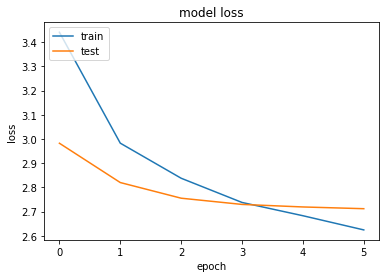

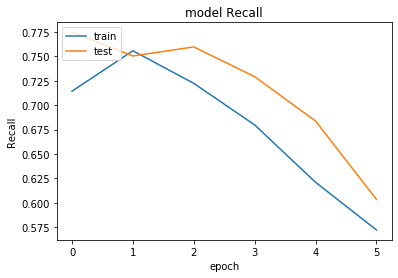

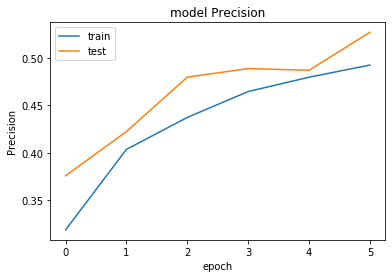

In [99]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
    
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['recall_5'])
plt.plot(history.history['val_recall_5'])

plt.title('model Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision_5'])
plt.plot(history.history['val_precision_5'])

plt.title('model Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [33]:
#tfidf_reversed_vocab

In [34]:
print( X_train_tfidf[1].shape)

(1, 16694)


In [35]:
print( X_train_mybag[1].shape)

(1, 9632)


In [36]:
X_train_tfidf_3d=X_train_tfidf.toarray()

In [37]:
print(X_train_tfidf_3d.shape)

(124848, 16694)


In [38]:
firstghalf=X_train_tfidf_3d[:62424,:]
secondhalf=X_train_tfidf_3d[62424:,:]

In [39]:
secondhalf.shape

(62424, 16694)

In [40]:
from numpy import  newaxis
firstghalf=firstghalf[:,:,newaxis]
secondhalf=secondhalf[:,:,newaxis]

In [41]:
X_train_tfidf_3d=np.concatenate((firstghalf,secondhalf))

In [44]:
print(X_train_tfidf_3d.shape)

(124848, 16694, 1)


In [45]:
X_test_tfidf_3d=X_test_tfidf.toarray()

In [46]:
print(X_test_tfidf_3d.shape)

(31212, 16694)


In [47]:
from numpy import  newaxis
X_test_tfidf_3d=X_test_tfidf_3d[:,:,newaxis]

In [48]:
print(X_test_tfidf_3d.shape)

(31212, 16694, 1)


In [51]:
#X_train_mybag_3d=X_train_mybag.toarray()
firstghalf=X_train_tfidf[:62424,:]
secondhalf=X_train_tfidf[62424:,:]
firstghalf =firstghalf.toarray()
secondhalf=secondhalf.toarray()

MemoryError: Unable to allocate 7.76 GiB for an array with shape (62424, 16694) and data type float64

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:

X_train_mybag_3d=X_train_mybag_3d[:,:,newaxis]

In [ ]:
print(X_train_mybag_3d.shape)

In [ ]:
X_test_mybag_3d=X_test_mybag.toarray()

In [ ]:
print(X_test_mybag_3d.shape)

In [ ]:

X_test_mybag_3d=X_test_mybag_3d[:,:,newaxis]

In [ ]:
print(X_test_mybag_3d.shape)